# DJ GAN

In [1]:
import numpy as np
import IPython
import matplotlib.pyplot as plt

## Generate dataset
We'll start by generating our own very simple dataset with sinusoidal waves with frequencies between 300 and 500 and amplitudes between 0.5 and 1.

In [2]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [3]:
def get_data_samples_square(N=1000, scale=[1, 1], offset=[0,-1]):
    data = []
    for i in range(N):
        f = np.random.random()*scale[0] + offset[0]
        A = np.random.random()*scale[0] + offset[1]
        sample = np.array([f, A])
        data.append(sample)
    
    return np.array(data)

def get_data_samples_gaussian(N=1000, dim=2, offset=5.5):
    data=[]
    for i in range(N):
        d = np.random.randn(dim)/100 + offset
        data.append(d)
    return np.array(data)
    

In [4]:
np.random.randn(2) + 5

array([4.18573711, 3.42927301])

In [5]:
# generate data set (numpy)
N_data = 1000
scale = [1,1]
offset = [5,5]
data = get_data_samples_square(N_data, scale, offset)
data.shape

(1000, 2)

In [6]:
data = get_data_samples_gaussian(N_data)

In [7]:
data.shape

(1000, 2)

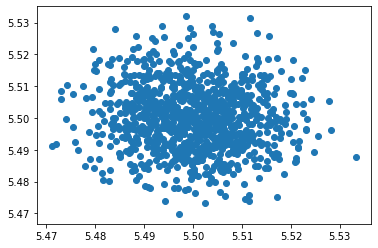

In [8]:
fig, ax = plt.subplots(1,1)
ax.scatter(data[:,0], data[:,1])

In [9]:
# create dataloader 
batch_size = 64

tensor_x = torch.Tensor(data) # transform to torch tensor

dataset = TensorDataset(tensor_x) # create your datset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # create your dataloader

## The networks
- Discriminator
- Generator

In [10]:
# discriminator network
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, 8),
                                    nn.ReLU(),
                                    #nn.Dropout(0.5),
                                    nn.Linear(8, 1),
                                    nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [11]:
# generator network
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, 16),
                                    nn.Tanh(),
                                    nn.Linear(16, 16),
                                    #nn.BatchNorm1d(50),
                                    nn.Tanh(),
                                    #nn.Dropout(0.5),
                                    nn.Linear(16, output_size),
                                    nn.LeakyReLU()
                                   )
        

    def forward(self, x):
        x = self.layers(x)
        return x

# Training and Evaluation
following the example in https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [12]:
# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# length of random vector
nz = 2

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()
#criterion = nn.

fixed_noise = torch.randn(256, nz, device=device)

# Establish convention for real and fake labels during training
real_label_disc = 1.0 #change to 0.9? one-sided label smoothing
real_label_gen = 1. 
fake_label = 0.

# networks
n_features = 2
netD = Discriminator(n_features)
netG = Generator(nz, n_features)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr)#, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr)#, betas=(beta1, 0.999))

In [14]:
# Lists to keep track of progress
freq_list = []
G_losses_epoch = []
D_losses_epoch = []
D_xs_epoch = []
D_G_z1s_epoch = []
D_G_z2s_epoch = []
iters = 0

In [15]:
# Training Loop (copy pasted training loop and sligthly modified, ofc, we have to do our own...)

# Number of training epochs
num_epochs = 1000

Train_D = True
Train_G = False

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    
    # For each batch in the dataloader
    G_losses = []
    D_losses = []
    D_xs = []
    D_G_z1s = []
    D_G_z2s = []
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real batch
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)
        #add_noise = torch.rand_like(real_cpu)*0.1 + 1
        #real_cpu = real_cpu*add_noise
        b_size = real_cpu.size(0)
        #rand_noise = np.random.normal(0, 0.02)*0
        label = torch.full((b_size,), real_label_disc, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch

        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)

        # Generate fake batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D as sum over the fake and the real batches
        errD = (errD_real + errD_fake)/2

        # Update D
        if Train_D:
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label_gen)  # fake labels are real for generator cost

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        #print(f"output shape = {output.shape}")

        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        if Train_G:
            optimizerG.step()

        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_xs.append(D_x)
        D_G_z1s.append(D_G_z1)
        D_G_z2s.append(D_G_z2)

        iters += 1
        
        
    
    # Save Losses for plotting later
    G_losses_epoch.append(np.mean(G_losses))
    D_losses_epoch.append(np.mean(D_losses))
    D_xs_epoch.append(np.mean(D_xs))
    D_G_z1s_epoch.append(np.mean(D_G_z1s))
    D_G_z2s_epoch.append(np.mean(D_G_z2s))
    
    #if epoch > 25:
    #    Train_G = True
        
    if epoch%50 == 0:
        Train_G = False
        
    if (epoch+25)%50 == 0:
        Train_G = True
        
#     if epoch > 250:
#         Train_G = False
    
#     if epoch > 275:
#         Train_G = True
    
    
#     if G_losses_epoch[-1] > D_losses_epoch[-1]:
#         Train_D = True
#         Train_G = True
#         #print('Train Generator')
#     else:
#         Train_D = True
#         Train_G = True
        #print('Train Discriminator')
    
    # Check how the generator is doing by saving G's output on fixed_noise
    with torch.no_grad():
        fake_t = netG(fixed_noise).detach().cpu().numpy()
    freq_list.append(fake_t)
        
    # Output training stats
    if epoch%25==0 or epoch==num_epochs - 1:
        print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f | (%.2f, %.2f), (%.2f, %.2f)'
              % (epoch+1, num_epochs,
                 D_losses_epoch[-1], G_losses_epoch[-1], D_xs_epoch[-1], 
                 D_G_z1s_epoch[-1], D_G_z2s_epoch[-1], 
                 freq_list[-1][:,0].min(), freq_list[-1][:,0].max(), freq_list[-1][:,1].min(), freq_list[-1][:,1].max()))

# D(x) from 1 to 0.5
# D(G(z)) from 0 to 0.5

Starting Training Loop...
[1/1000] 	Loss_D: 0.5388	Loss_G: 0.6442	D(x): 0.7182	D(G(z)): 0.5260 / 0.5251 | (-0.01, 0.24), (-0.00, 0.05)
[26/1000] 	Loss_D: 0.1518	Loss_G: 1.3964	D(x): 0.9817	D(G(z)): 0.2480 / 0.2475 | (-0.01, 0.24), (-0.00, 0.05)
[51/1000] 	Loss_D: 0.7814	Loss_G: 0.7166	D(x): 0.4110	D(G(z)): 0.4902 / 0.4885 | (6.87, 7.46), (5.92, 6.29)
[76/1000] 	Loss_D: 0.3113	Loss_G: 1.4464	D(x): 0.7036	D(G(z)): 0.2370 / 0.2365 | (6.87, 7.46), (5.92, 6.29)
[101/1000] 	Loss_D: 0.5122	Loss_G: 1.0147	D(x): 0.5664	D(G(z)): 0.3661 / 0.3627 | (5.76, 6.30), (8.66, 8.86)
[126/1000] 	Loss_D: 0.1731	Loss_G: 2.0101	D(x): 0.8179	D(G(z)): 0.1351 / 0.1347 | (5.76, 6.30), (8.66, 8.86)
[151/1000] 	Loss_D: 0.5942	Loss_G: 0.5817	D(x): 0.6945	D(G(z)): 0.5610 / 0.5591 | (2.46, 3.65), (1.73, 3.16)
[176/1000] 	Loss_D: 0.4118	Loss_G: 0.8893	D(x): 0.7477	D(G(z)): 0.4125 / 0.4121 | (2.46, 3.65), (1.73, 3.16)
[201/1000] 	Loss_D: 0.7936	Loss_G: 0.7940	D(x): 0.3739	D(G(z)): 0.4531 / 0.4520 | (7.37, 7.60), (8.11, 

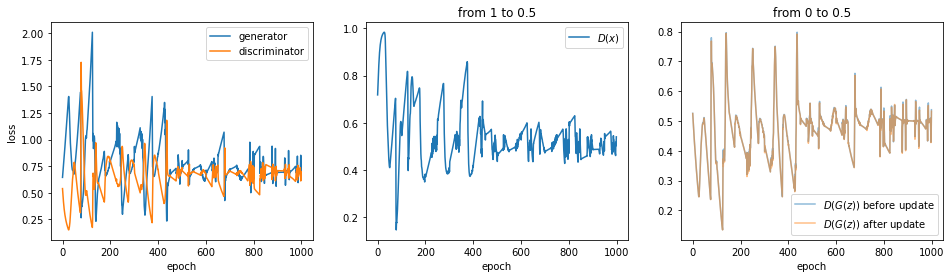

In [16]:
fig, axs = plt.subplots(1,3, figsize=(16,4))
ax=axs[0]
ax.plot(G_losses_epoch, label='generator')
ax.plot(D_losses_epoch, label='discriminator')
ax.set(xlabel='epoch', ylabel='loss')
ax.legend()

ax=axs[1]
ax.plot(D_xs_epoch, label=r"$D(x)$")
ax.legend()
ax.set(title='from 1 to 0.5', xlabel='epoch')

ax=axs[2]
ax.plot(D_G_z1s_epoch, alpha=0.5, label=r"$D(G(z))$ before update")
ax.plot(D_G_z2s_epoch, alpha=0.5, label=r"$D(G(z))$ after update")
ax.legend()
ax.set(title='from 0 to 0.5', xlabel='epoch');

0


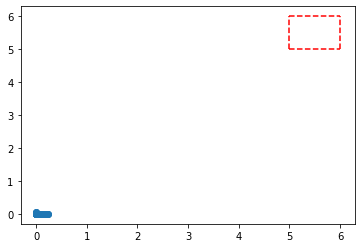

25


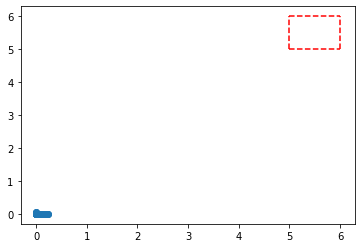

50


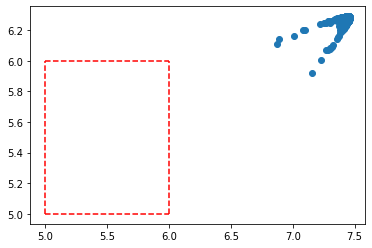

75


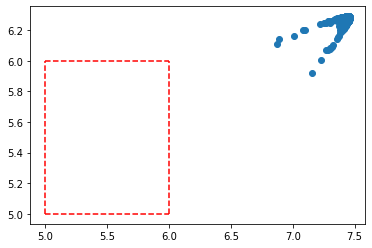

100


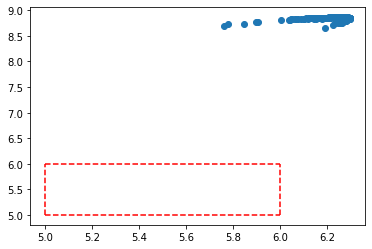

125


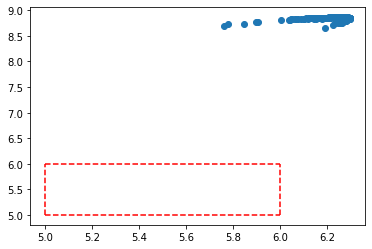

150


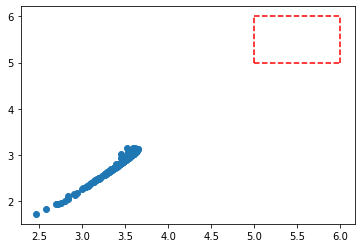

175


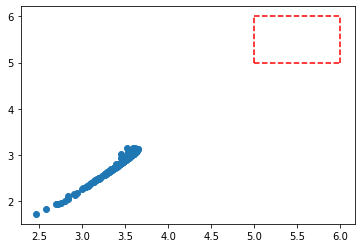

200


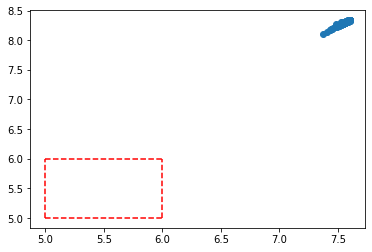

225


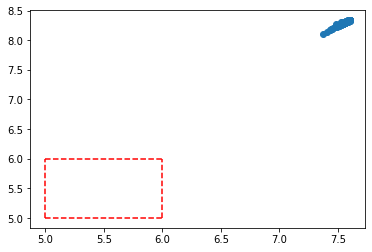

250


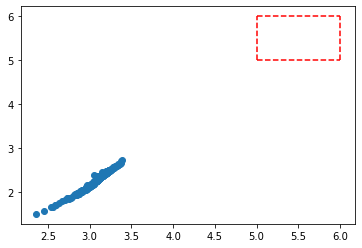

275


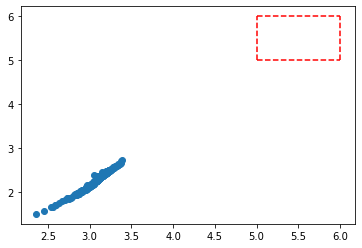

300


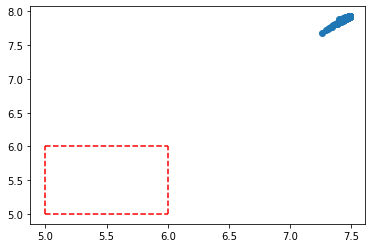

325


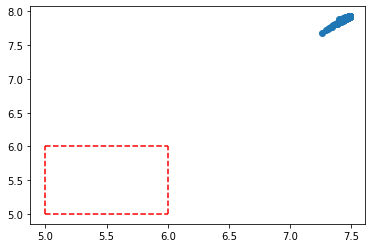

350


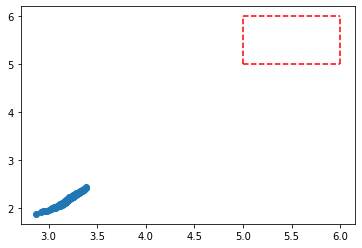

375


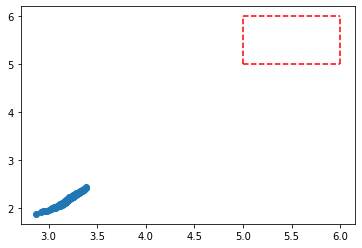

400


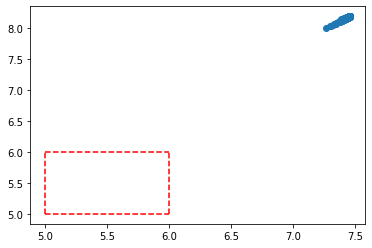

425


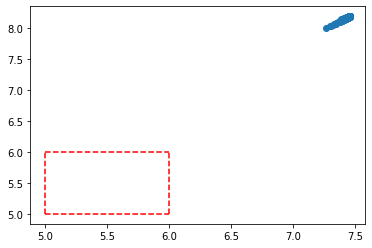

450


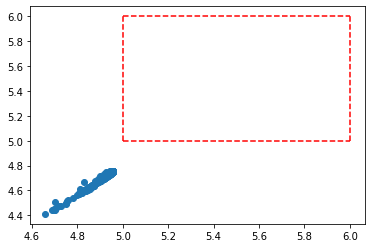

475


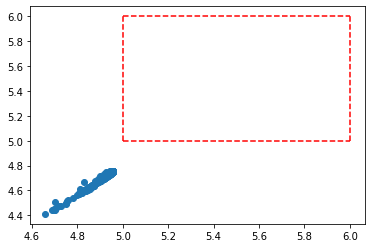

500


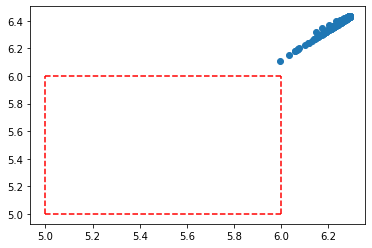

525


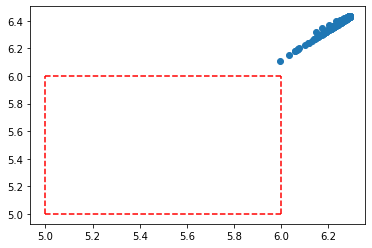

550


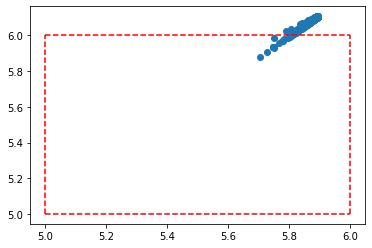

575


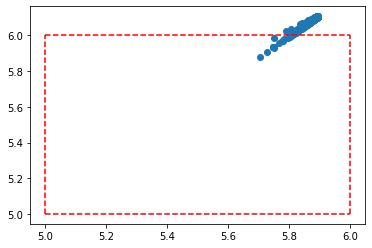

600


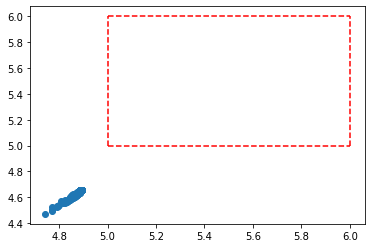

625


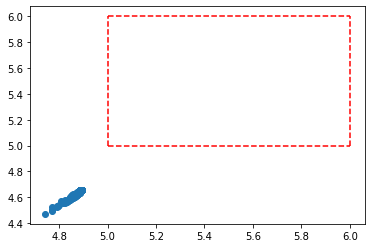

650


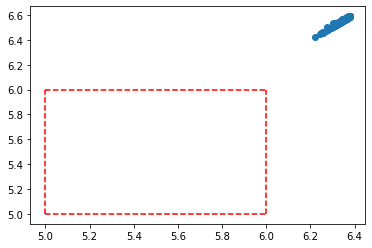

675


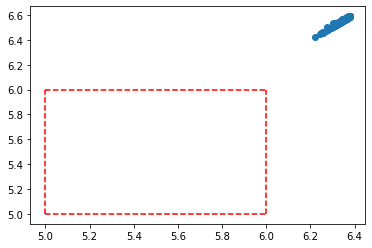

700


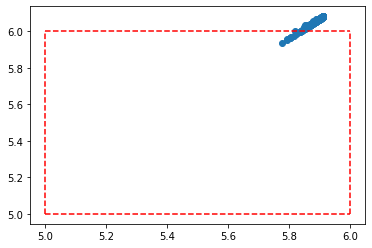

725


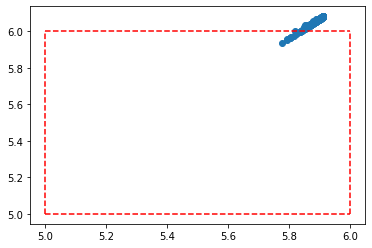

750


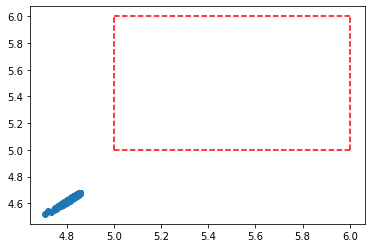

775


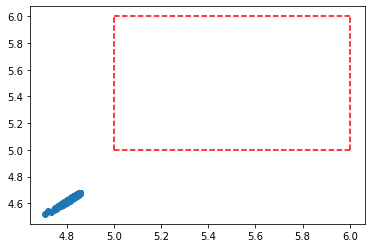

800


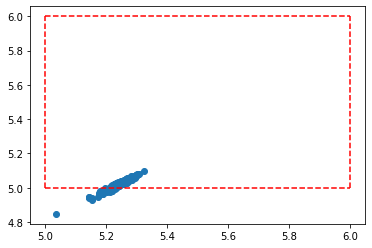

825


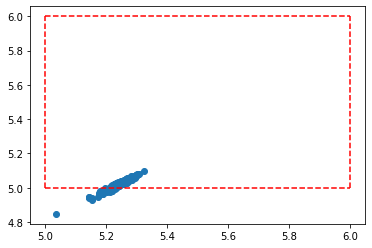

850


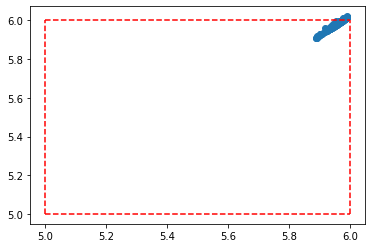

875


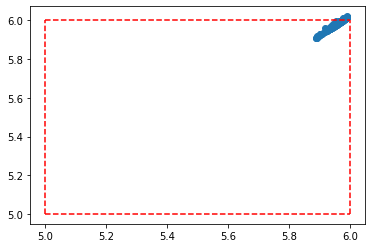

900


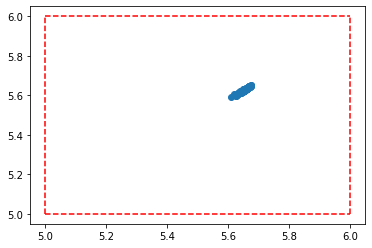

925


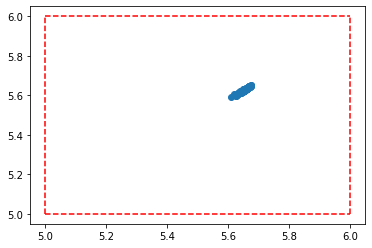

950


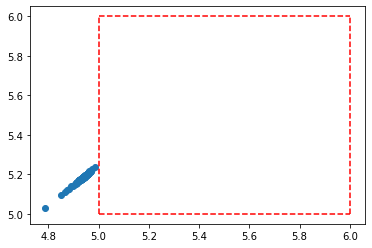

975


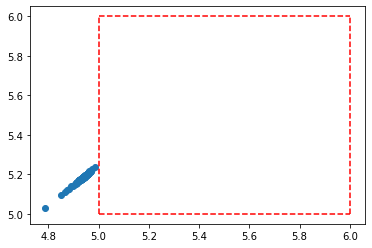

999


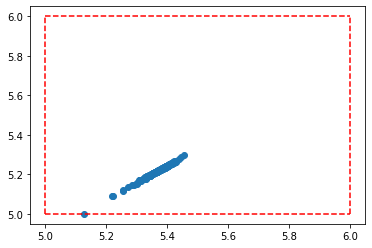

In [17]:
f_min=[offset[0], offset[0]]
f_max=[offset[0] + scale[0], offset[0] + scale[0]]

for i in range(len(freq_list)):
    if i%25==0 or i==len(freq_list)-1:
        print(i)
        fig, ax = plt.subplots(1,1)
        ax.scatter(freq_list[i][:,0], freq_list[i][:,1])
        ax.plot([f_min[0], f_max[0]], [f_min[1], f_min[1]], '--r', label='target class')
        ax.plot([f_min[0], f_max[0]], [f_max[1], f_max[1]], '--r')
        ax.plot([f_min[0], f_min[0]], [f_min[1], f_max[1]], '--r')
        ax.plot([f_max[0], f_max[0]], [f_min[1], f_max[1]], '--r')
        plt.show()